In [1]:
# Imports

import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from tqdm import tqdm

In [2]:
# Paths

data_path = "../../data/short-raw-refs-abs"
table_path = "../../reports/tables"
figure_path = "../../reports/figures"

In [25]:
# Constants

CREATE_ABSTRACTS_DATASET = True

# Number of topics used for K-means
n_topics = 8

#### Create Abstracts dataset (only need to do this once)

In [26]:
# Helper: Clean Abstracts
# Basic text cleaning

def clean_text(text):
    if not isinstance(text, str):
        return ""

    # Remove Scopus copyright header 
    text = re.sub(r"^©\s*\d{0,4}\s*the author\(s\)\s*", "", text, flags=re.IGNORECASE)

    # Then apply the normal cleaning
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()


In [30]:
DATA_PATH = Path(data_path)  # folder with subfolders per query
records = []

if CREATE_ABSTRACTS_DATASET:

    for folder in sorted(DATA_PATH.iterdir()):
        if not folder.is_dir():
            continue
        query_id = folder.name
        jsonl_files = list(folder.glob("*.jsonl"))
        for fp in jsonl_files:
            with fp.open("r", encoding="utf-8") as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    try:
                        rec = json.loads(line)
                    except json.JSONDecodeError:
                        continue

                    abs_txt = rec.get("abstract") or rec.get("description") or ""
                    if isinstance(abs_txt, list):
                        abs_txt = " ".join(str(x) for x in abs_txt if x)

                    # Cover date was not included in last script
                    records.append({
                        "query_id": query_id,
                        "eid": rec.get("eid"),
                        "doi": rec.get("doi"),
                        "title": rec.get("title"),
                        # "coverDate": rec.get("coverDate"),
                        "abstract": abs_txt.strip()
                    })

    df = pd.DataFrame(records)
    
    # Remove empty abstracts early
    df = df[df["abstract"].notna() & (df["abstract"].str.strip() != "")]
    df = df.reset_index(drop=True)
    
    # Clean abstracts
    df["clean_abs"] = df["abstract"].apply(clean_text)
    
    print(f"\nCollected {len(df)} abstracts from {len(df['query_id'].unique())} queries")

    # Save for later analysis
    out_path = Path("../../data/processed/abstracts.csv")
    df.to_csv(out_path, index=False)
    print(f"Saved: {out_path}")



Collected 32714 abstracts from 17 queries
Saved: ../../data/processed/abstracts.csv


In [28]:
# Load dataframe with abstracts
# Only if it has been created earlier

if not CREATE_ABSTRACTS_DATASET:
    df = pd.read_csv("../../data/processed/abstracts.csv") 
    print(f"Loaded {len(df)} abstracts")


In [31]:
df.head(2)

,query_id,eid,doi,title,abstract,clean_abs
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,the detection of anomalies in production proce...
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",under exclusive license to springer nature swi...


In [24]:
# TF-IDF vectorization

# Convert cleaned abstracts to TF-IDF features
tfidf = TfidfVectorizer(max_features=5000, stop_words="english")
X = tfidf.fit_transform(df["clean_abs"])

print(f"TF-IDF shape: {X.shape}")


TF-IDF shape: (32714, 5000)


In [8]:
# K-Means topic clustering

km = KMeans(n_clusters=n_topics, random_state=42)
df["topic"] = km.fit_predict(X)

df["topic"].value_counts().sort_index()

topic
0     1264
1     1772
2     4338
3     5370
4     2571
5     3981
6     3051
7    10367
Name: count, dtype: int64

In [9]:
# Show top TF-IDF words per topic
terms = tfidf.get_feature_names_out()

for i in range(n_topics):
    idx = km.cluster_centers_[i].argsort()[::-1][:10]
    top_terms = [terms[j] for j in idx]
    print(f"Topic {i}: {', '.join(top_terms)}")


Topic 0: rul, battery, life, prediction, remaining, useful, degradation, batteries, health, data
Topic 1: ai, intelligence, artificial, manufacturing, technologies, ml, systems, industry, food, applications
Topic 2: process, manufacturing, quality, parameters, control, ml, data, optimization, printing, machine
Topic 3: energy, model, production, models, prediction, optimization, data, study, learning, forecasting
Topic 4: maintenance, predictive, data, equipment, failure, failures, machine, pdm, learning, industrial
Topic 5: digital, manufacturing, data, industry, systems, technologies, smart, production, industrial, learning
Topic 6: detection, defect, data, classification, fault, defects, learning, anomaly, using, model
Topic 7: design, data, learning, model, machine, process, production, optimization, using, method


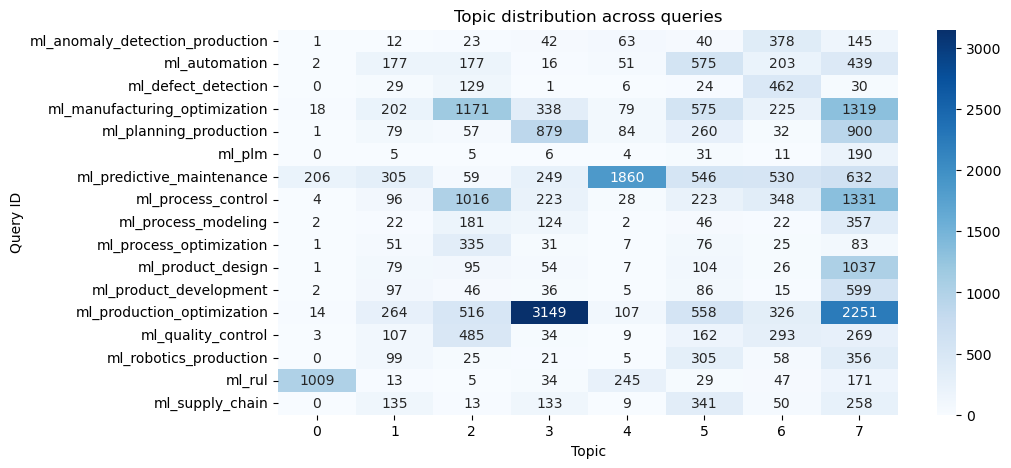

In [10]:
# Count how many abstracts per query belong to each topic
topic_dist = df.groupby(["query_id", "topic"]).size().unstack(fill_value=0)

plt.figure(figsize=(10,5))
sns.heatmap(topic_dist, cmap="Blues", annot=True, fmt="d")
plt.title("Topic distribution across queries")
plt.ylabel("Query ID")
plt.xlabel("Topic")
plt.show()


In [11]:
# Save results for later analysis
df.to_csv("../../reports/tables/abstract_topics.csv", index=False)
print("Saved topic assignments to ../reports/tables/abstract_topics.csv")


Saved topic assignments to ../reports/tables/abstract_topics.csv
